# Question 1

In [1]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt

In [2]:
counter = 0
random_state = 23
k = 3
N = [5, 10, 30]
size = 100000

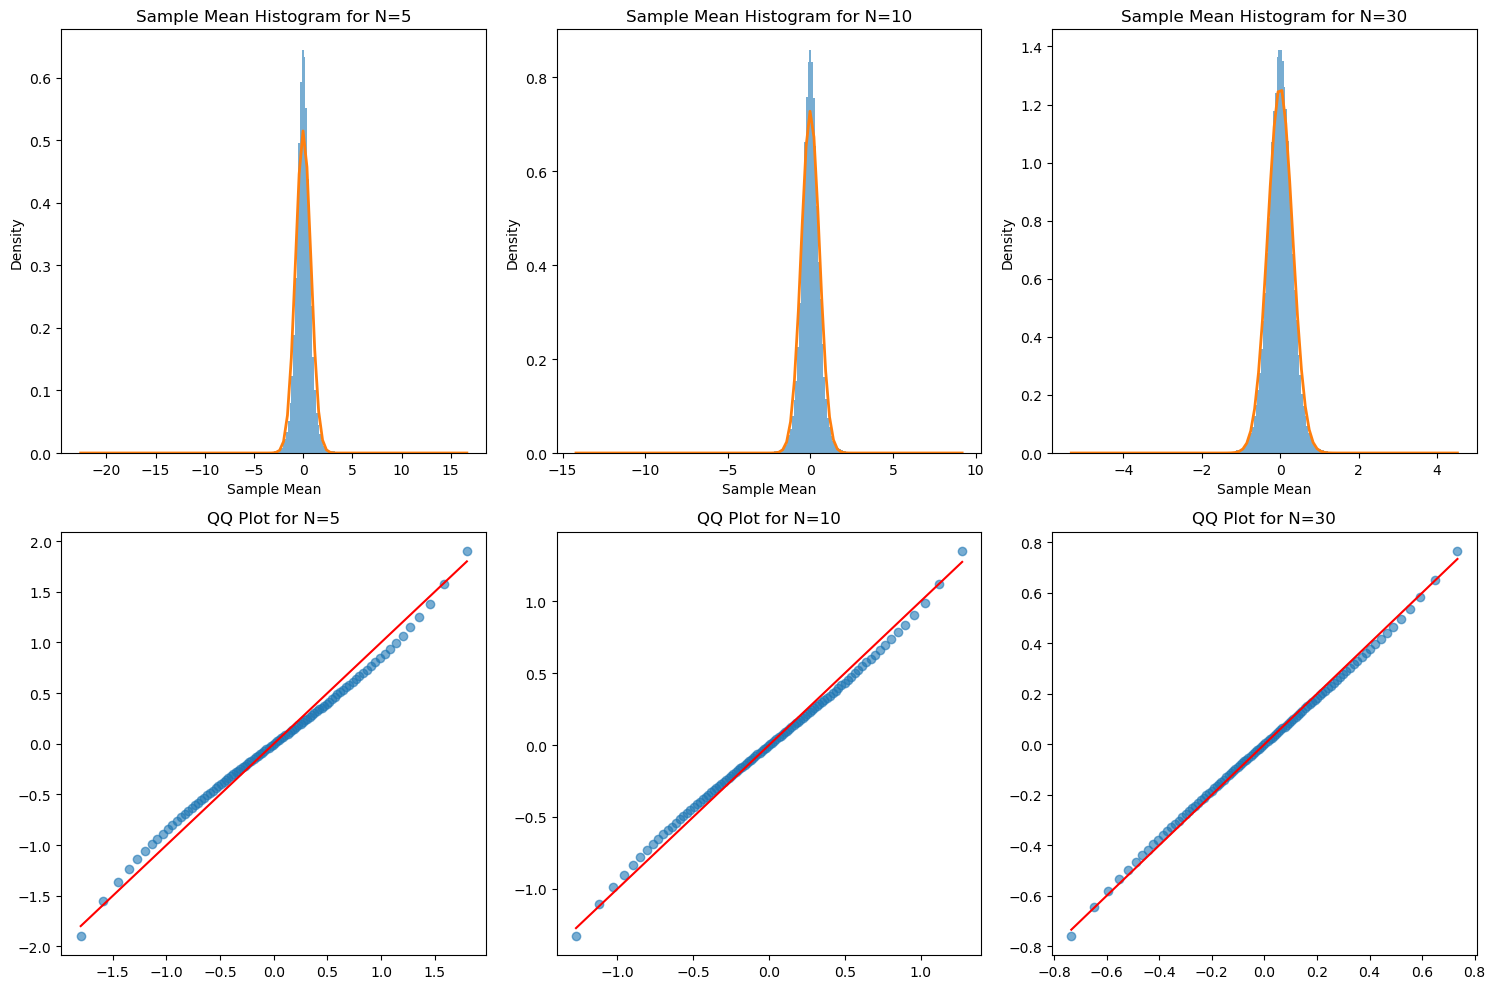

In [3]:
# Create 2x3 subplot grid
fig, axs= plt.subplots(2, 3, figsize=(15, 10))

for n in N:
    samples = stats.t.rvs(df=k, loc=0, size=(size,n),random_state=random_state)
    sample_mean = np.mean(samples, axis=1)                     
    #print(sampleMean)
    ax = axs[counter // 3, counter % 3]
    ax.hist(sample_mean, bins=200, density=True, alpha=0.6)
    ax.set_title(f'Sample Mean Histogram for N={n}')
    ax.set_xlabel('Sample Mean')
    ax.set_ylabel('Density')
    

    mean = 0  # As per the CLT
    var = (k / (k - 2))/n  # Variance as per the CLT
    std = np.sqrt(var)

    # Generate values for the normal distribution curve
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mean, std)
    

    # Plot the normal distribution curve
    ax.plot(x, p, linewidth=2)


    ax = axs[(counter + 3) // 3, (counter + 3) % 3]
    sm_quantiles = np.percentile(sample_mean, np.linspace(0, 100, 100))
    th_quantiles = stats.norm.ppf(np.linspace(0, 1, 100), loc=mean, scale=std)
    ax.plot(th_quantiles, sm_quantiles, 'o', alpha=0.6)
    ax.plot(th_quantiles, th_quantiles, 'r-')
    ax.set_title(f'QQ Plot for N={n}')
    counter = counter + 1


fig.tight_layout()
plt.show()

### Going by the defination of CLT, regardless of the shape of the original population distribution (here, Student's t distribution), the distribution of the sample mean of a sufficiently large sample from that population will be approximately normally distributed. Thus for a sample size of N=30 we see the approximate density of sample means given by the CLT seems to be a good approximation of the sample means of actual distribution.

### Also by the judging by the QQ plot as the sample size increases from 5 - 30, the normal distribution curve fits the distribution of sample mean. 

# Question 2

In [4]:
!pip install pandas_datareader -q

In [5]:
import pandas_datareader.data as web
from datetime import datetime

In [6]:
start = datetime(1995, 1, 1)
end = datetime(2023, 11, 14)
data = web.DataReader('^DJI', 'stooq', start ,end)
data = data.reset_index()
dates = data["Date"]
dow = data["Close"].to_numpy()

## a) Plot this times series.

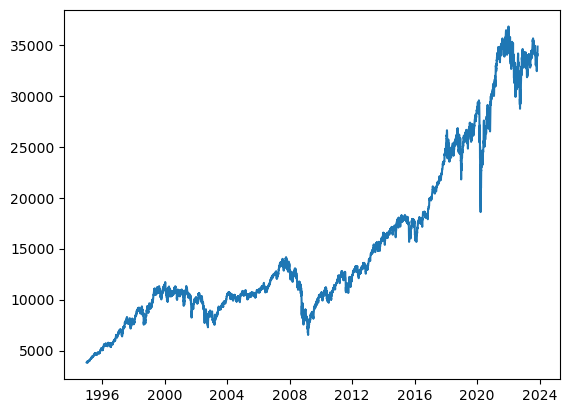

In [7]:
plt.plot(dates, dow)

## b)

In [8]:
daily_returns = []
for i in range(1, len(dow)):
    if i!=len(dow):
        returns = 100 * ((dow[i]/dow[i-1])-1)
        daily_returns.append(returns)

## c)

In [15]:
daily_100_returns = [np.mean(daily_returns[:_]) for _ in range(100, len(daily_returns))]

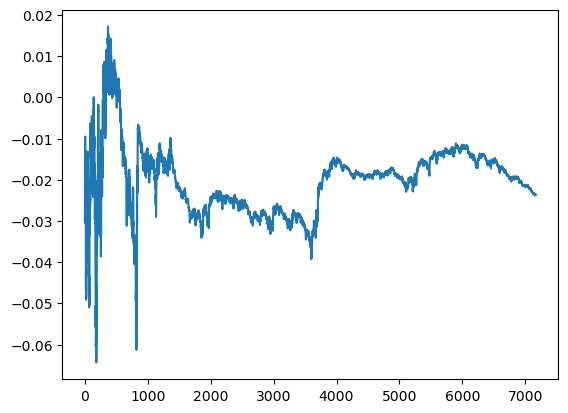

In [21]:
plt.plot(daily_100_returns)
plt.show()

##  The Weak Law of Large Numbers states that as the sample size (n) increases, the sample mean converges in probability to the true population mean, this seems to holds.

In [18]:
daily_400_returns = [np.mean(daily_returns[:_]) for _ in range(400, len(daily_returns))]

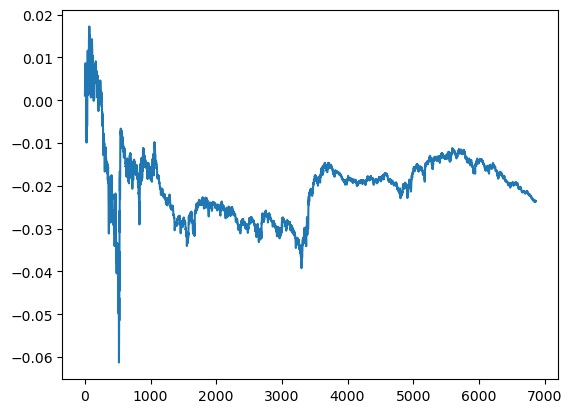

In [65]:
plt.plot(daily_400_returns)
plt.show()

## d)

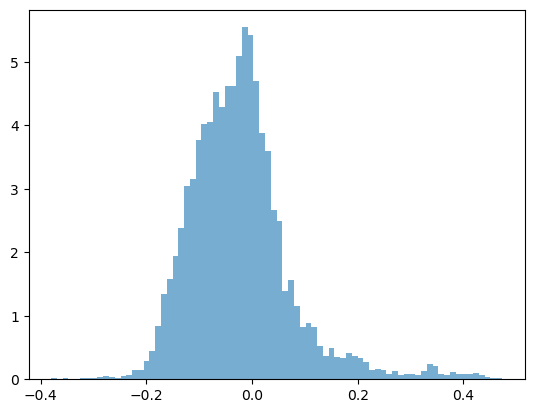

In [81]:
plt.hist([np.mean(daily_returns[i:i+100]) for i in range(len(daily_returns)-100)], bins='auto', density=True, alpha=0.6)
plt.show()

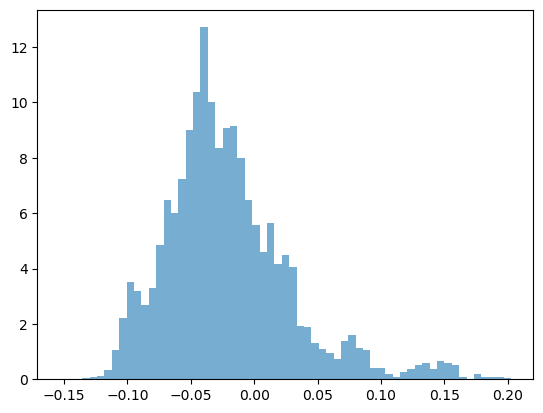

In [83]:
plt.hist([np.mean(daily_returns[i:i+400]) for i in range(len(daily_returns)-400)], bins='auto', density=True, alpha=0.6)
plt.show()

## Althogh the plots resembles the normal distribution visually, it doesn't obey central limit theorem for 2 reasons, 
## 1) high kurtosis 
## 2) these are not independent variable as the smaplings were done by using means of previous 100/400 samples.

## e)

In [109]:
[np.mean(daily_returns), np.var(daily_returns), stats.skew(daily_returns, bias=False), stats.kurtosis(daily_returns, bias=False)]

[-0.023722955410124806,
 1.3280669272904766,
 0.6481969061545363,
 12.987573014493178]

## The kurtosis is quite high for a normally distributed data and thus we are on a lookout for a distribution that handles high kurtosis, like Student's T and Cauchy distributions. 

## f)

## I've opted for Student's T distribution based on negligible skew and high kurtosis

In [113]:
def objective_fn(params , x):
    df, mean, std = params
    return - np.sum(np.log(stats.t.pdf(x, df, mean, std)))

initial_params = [1.5 , np.mean(daily_returns), np.std(daily_returns)]
parameter_bounds = [(1,3), (None, None), (None,None)]
result = opt.minimize(objective_fn, initial_params, args=(daily_returns,), bounds=parameter_bounds)
optimized_params = result.x

print("Optimized Parameters:", optimized_params)

Optimized Parameters: [ 2.85349199 -0.06273686  0.68881383]


In [120]:
x = np.linspace(-10, 10, 1000)
y = stats.t.pdf(x, df=optimized_params[0], loc=optimized_params[1], scale=optimized_params[2])

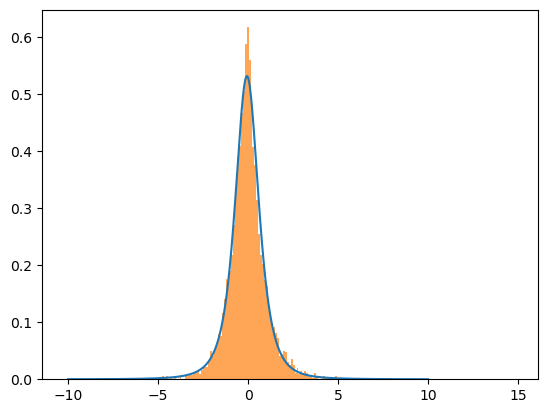

In [127]:
plt.plot(x, y)
plt.hist(daily_returns, bins='auto', density=True, alpha=0.7)
plt.show()

## e)

In [147]:
bounds = [(1, 2.99), (-1,1), (0,2)]  # from prev params
res = stats.fit(stats.t, daily_returns, bounds)

In [148]:
res.params

FitParams(df=2.8534885476136056, loc=-0.06273694302670199, scale=0.6888138387003063)

In [149]:
x = np.linspace(-10, 10, 1000)
y = stats.t.pdf(x, *res.params)

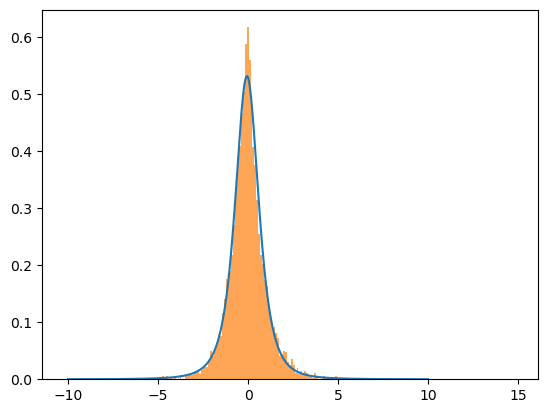

In [150]:
plt.plot(x, y)
plt.hist(daily_returns, bins='auto', density=True, alpha=0.7)
plt.show()